In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import scipy.stats
import theano.tensor as tt


In [2]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Simulation data

In [3]:
k = 4
conc = 2.0
frac = np.ones(k) / k
n_samples = 10
total_count = np.round(np.linspace(10, 100, num=n_samples))

p = sp.stats.dirichlet(conc * frac).rvs(size=n_samples)
y = np.stack([sp.stats.multinomial(n=total_count[i], p=p[i, :]).rvs()[0] for i in range(n_samples)])
y

array([[ 8,  0,  1,  1],
       [ 9, 10,  1,  0],
       [ 4,  0, 24,  2],
       [40,  0,  0,  0],
       [33,  8,  9,  0],
       [ 3,  0, 55,  2],
       [ 0,  7, 59,  4],
       [13,  0, 15, 52],
       [41,  1,  4, 44],
       [18, 51, 27,  4]])

## Explicit Model

In [4]:
with pm.Model() as model_explicit:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    pi = pm.Dirichlet("pi", a=a * alpha, shape=(n_samples, k))
    obs = pm.Multinomial("obs", n=total_count, p=pi, shape=(n_samples, k), observed=y)

    trace_explicit = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [pi, alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
The acceptance probability does not match the target. It is 0.90626084902764, but should be close to 0.8. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

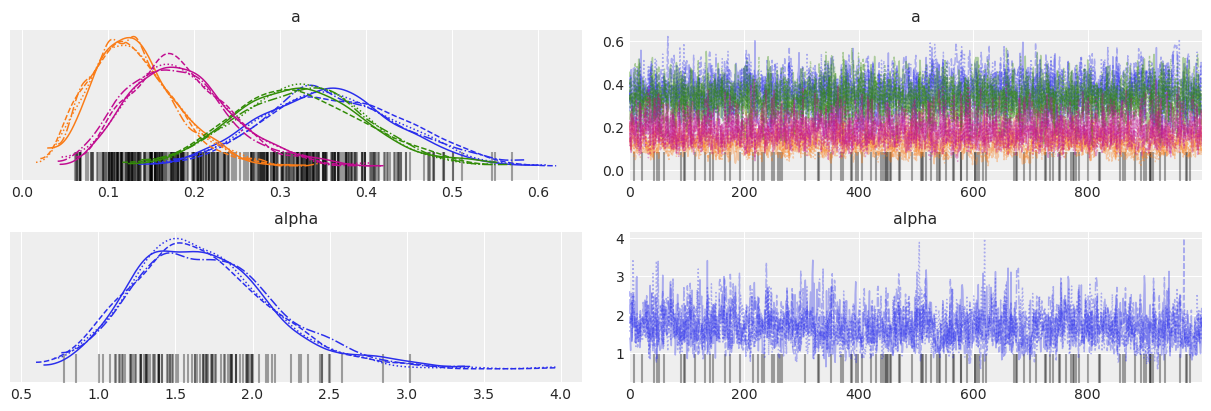

In [5]:
az.plot_trace(data=trace_explicit, var_names=["a", "alpha"], compact=True)

In [6]:
az.summary(trace_explicit, var_names=["a", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.360,0.079,0.211,0.506,0.002,0.001,2122.0,2095.0,2122.0,2418.0,1.0
a[1],0.131,0.050,0.047,0.226,0.002,0.001,835.0,835.0,745.0,896.0,1.0
a[2],0.325,0.075,0.189,0.469,0.002,0.001,2394.0,2375.0,2383.0,2470.0,1.0
a[3],0.184,0.060,0.068,0.288,0.001,0.001,1788.0,1788.0,1614.0,1984.0,1.0
alpha,1.685,0.451,0.893,2.531,0.015,0.011,863.0,863.0,798.0,1406.0,1.0


## Marginalized model

In [7]:
with pm.Model() as model_marginalized:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    obs = pm.DirichletMultinomial(
        "obs", n=total_count, a=a * alpha, shape=(n_samples, k), observed=y
    )

    trace_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

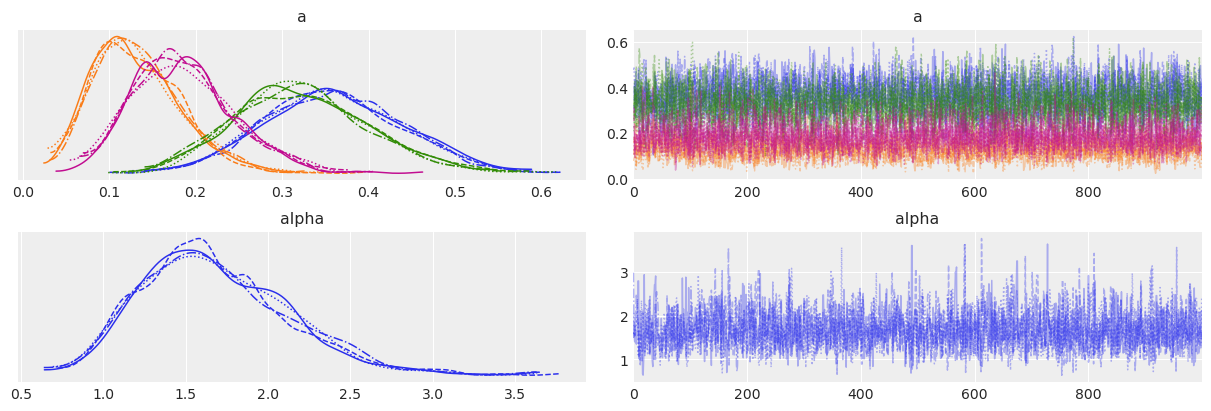

In [8]:
az.plot_trace(data=trace_marginalized, var_names=["a", "alpha"], compact=True)

In [9]:
summary_marginalized = az.summary(trace_marginalized, var_names=["a", "alpha"])
summary_marginalized

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.359,0.079,0.217,0.509,0.001,0.001,3193.0,3193.0,3173.0,2382.0,1.0
a[1],0.132,0.050,0.041,0.222,0.001,0.001,2479.0,2479.0,2342.0,2080.0,1.0
a[2],0.323,0.077,0.173,0.458,0.001,0.001,2803.0,2803.0,2751.0,2300.0,1.0
a[3],0.186,0.058,0.087,0.301,0.001,0.001,3804.0,3646.0,3844.0,2935.0,1.0
alpha,1.676,0.449,0.893,2.477,0.009,0.006,2628.0,2584.0,2640.0,2255.0,1.0


In [10]:
assert all(summary_marginalized.r_hat < 1.03)

In [11]:
with model_marginalized:
    ppc = pm.sample_posterior_predictive(trace_marginalized)
# ppc['obs'].squeeze()

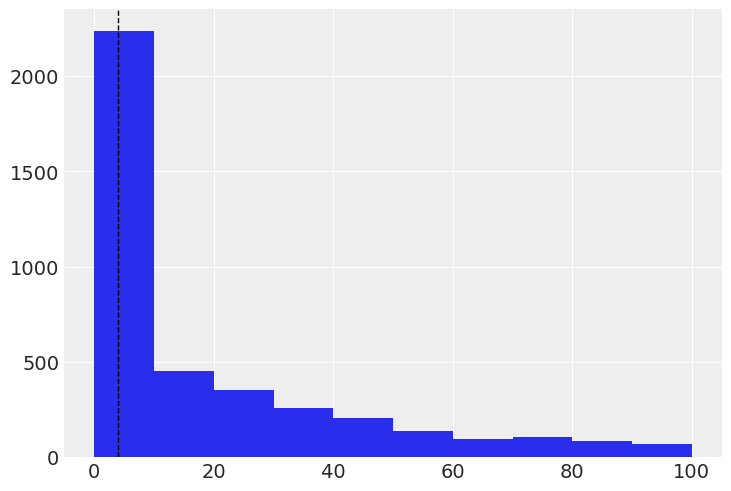

In [12]:
i, j = 9, 3
plt.hist(ppc["obs"][:, i, j])
plt.axvline(y[i, j], lw=1, linestyle="--", color="k")

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 04 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

scipy     : 1.6.0
numpy     : 1.19.4
theano    : 1.0.14
pymc3     : 3.10.0
arviz     : 0.10.0
matplotlib: 3.3.3
json      : 2.0.9

Watermark: 2.1.0

